In [1]:
!pip install -q datasets transformers torch scikit-learn nltk spacy
!python -m spacy download en_core_web_sm



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------- ----------------- 7.3/12.8 MB 37.8 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 31.5 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 26.7 MB/s  0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import sys
!{sys.executable} -m pip install tf-keras


  Using cached tf_keras-2.20.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tf_keras-2.20.1-py3-none-any.whl (1.7 MB)
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
    --------------------------------------- 5.0/331.9 MB 60.5 MB/s eta 0:00:06
   -- ------------------------------------- 16.8/331.9 MB 55.8 MB/s eta 0:00:06
   --- ------------------------------------ 29.9/331.9 MB 59.2 MB/s eta 0:00:06
   ----- ---------------------------------- 43.0/331.9 MB 59.5 MB/s eta 0:00:05
   ------ --------------------------------- 54.5/331.9 MB 58.9 MB/s eta 0:00:05
   -------- ------------------------------- 67.4/331.9 MB 58.9 MB/s eta 0:00:05
   --------- ------------------------------ 77.1/331.9 MB 57.8 MB/s eta 0:00:05
   ---------- ----------------------------- 88.6/331.9 MB 56.6 MB/s eta 0:00:05
   ----------- --------------------------- 101.2/331.9 MB 57.2 MB/s eta 0:00:05
   ------------- ---

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.1 which is incompatible.


In [3]:
import sys
!{sys.executable} -m pip install wordcloud


In [4]:
import sys
!{sys.executable} -m pip install tensorflow==2.19.0


  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl (376.0 MB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)

  Attempting uninstall: protobuf

    Found existing installation: protobuf 6.33.1

    Uninstalling protobuf-6.33.1:

      Successfully uninstalled protobuf-6.33.1

   ---------------------------------------- 0/3 [protobuf]
   ---------------------------------------- 0/3 [protobuf]
   ---------------------------------------- 0/3 [protobuf]
   ---------------------------------------- 0/3 [protobuf]
   ---------------------------------------- 0/3 [protobuf]
   ---------------------------------------- 0/3 [protobuf]
   ---------------------------------------- 0/3 [protobuf]
   ---------------------------------------- 0/3 [protobuf]
   ---------------------------------------- 0/3 [protobuf]
   --------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.20.1 requires tensorflow<2.21,>=2.20, but you have tensorflow 2.19.0 which is incompatible.


In [6]:
# General
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import string

# NLP
import re
import nltk
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud


# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report, roc_curve
)


import tensorflow as tf
from tensorflow.keras import layers, models

# HuggingFace
from datasets import load_dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Torch
import torch
from torch.utils.data import Dataset
from tensorflow.keras.callbacks import EarlyStopping


# Init
nlp = spacy.load("en_core_web_sm")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tarun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\tarun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import pickle

with open("saved_train_test.pkl", "rb") as f:
    data = pickle.load(f)

train_df = data["train_df"]
test_df = data["test_df"]


In [4]:
N = 20000  # samples per class

ds = load_dataset("artem9k/ai-text-detection-pile", split="train", streaming=True)

human, ai = [], []

for row in ds:
    if row["source"] == "human" and len(human) < N:
        human.append(row)
    elif row["source"] == "ai" and len(ai) < N:
        ai.append(row)
    if len(human) == N and len(ai) == N:
        break

df = pd.concat([pd.DataFrame(human), pd.DataFrame(ai)], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df["label"] = df["source"].apply(lambda x: 0 if x=="human" else 1)
df.head(), df["label"].value_counts()


KeyboardInterrupt: 

In [4]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", " ", text)
    doc = nlp(text)
    tokens = [t.lemma_ for t in doc if t.text.lower() not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)


In [ ]:
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

X_train = train_df["clean_text"].tolist()
y_train = train_df["label"].values
X_test = test_df["clean_text"].tolist()
y_test = test_df["label"].values


In [8]:

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),              
    max_features=5000,
    lowercase=True,
    stop_words='english'
)

X = vectorizer.fit_transform(train_df["text"])
X_test = vectorizer.transform(test_df["text"])

y = train_df["label"].values
y_test = test_df["label"].values

X.shape, X_test.shape


((32000, 5000), (8000, 5000))

In [9]:
mlp_model = models.Sequential([
    layers.Input(shape=(5000,)),     
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         320,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,129 (1.22 MB)

 Trainable params: 320,129 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = mlp_model.fit(
    X.toarray(), y,
    validation_split=0.2,
    epochs=3,           
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/3
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9713 - loss: 0.1742 - val_accuracy: 0.9923 - val_loss: 0.0374
Epoch 2/3
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9949 - loss: 0.0270 - val_accuracy: 0.9956 - val_loss: 0.0197
Epoch 3/3
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9978 - loss: 0.0131 - val_accuracy: 0.9955 - val_loss: 0.0149


In [11]:

y_pred_proba = mlp_model.predict(X_test.toarray())
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("MLP Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
MLP Results:
Accuracy:  0.9954
Precision: 0.9965
Recall:    0.9942
F1 Score:  0.9954
AUC-ROC:   0.9999


In [15]:

pd.set_option('display.max_colwidth', None)

# Get probability predictions
y_pred_proba = mlp_model.predict(X_test.toarray())
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Find all misclassified indices
mis_idx = np.where(y_pred != y_test)[0]

# Collect first 5 misclassified examples
examples = []
for i in mis_idx[:5]:
    examples.append({
        "text": test_df.iloc[i]["text"],
        "true_label": int(y_test[i]),
        "predicted_label": int(y_pred[i])
    })

misclassified_df = pd.DataFrame(examples)
misclassified_df

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,text,true_label,predicted_label
0,"\n\nIn the past year, cryptocurrency trading has been on the rise globally. The total market capitalization of cryptocurrency at the beginning of 2021 was more than $1 trillion, representing a 160% increase from the prior year. Bitcoin, the most widely traded cryptocurrency, has seen its price surge from around $10,000 to close to $60,000 on its 10th anniversary in January. Ethereum was up nearly 400%, while smaller tokens, such as Litecoin, have registered gains of over 1,000%. Overall, the cryptocurrency market has been bullish and is expected to continue to be so, as more investors pour in.",1,0
1,"\n\nThe past five years of nominees for Best Picture at the Academy Awards are: Moonlight (2016), The Shape of Water (2017), Green Book (2018), Parasite (2019), and Nomadland (2020).",1,0
2,"Dating in Los Angeles: The City of Dreams That Come True Essay (Article)\n\nBeing one of the most romantic places to be in, the City of Angels has a unique appeal that creates a perfect environment for a date. The inimitable atmosphere of Los Angeles is so powerful that even a plain evening walk turns into a date under a sky full of stars. However, to make the date even more special, one may want to consider several particularly special places for dating in Los Angeles.\n\nAn animal café, of which there is a plenty in Los Angeles, could seem a trivial idea, yet it offers a tremendous amount of cuteness that not a single couple will resist. The calm and soothing environment that the purr of cats creates will set the mood for a quiet and happy day out, when comfort and coziness are prioritized. Of all the dating ideas in Los Angeles, visiting an animal café is the most satisfying one for any couple since it does not contain any inherent challenges and only invites a couple to relax.\n\nHowever, when exploring less trivial ideas for dating in Los Angeles, one may also consider the Rooftop Cinema Club as a perfect venue for a date. The Rooftop Cinema Club provides an open-air experience that a couple will enjoy immensely due to the cozy setting and the opportunity to enjoy the company of each other despite being among others. Speaking of nontrivial, the Temescal Canyon is a fantastic place to consider when going on a date. Offering unforgettable views and a truly breathtaking experience, it provides its visitors with a chance to explore and discover.\n\nTurning to more traditional dating opportunities and the options for spending time together, one should take a closer look at restaurants in Old Town Pasadena. These places are perfect for two people who want to enjoy the company of themselves while exploring the beauty of the local environment. Moreover, for those willing to take their dating to a new and a more extreme level, one might want to suggest visiting one of the escape room in Los Angeles.\n\nOne might argue that the idea of an escape room, with its multiple spooky elements does not quite align with the concept of a romantic date. However, for a couple that has been dating for a while and needs a refreshing experience, an escape room in Los Angeles will be quite the challenge that will breathe a new life into one’s relationships.\n\nHowever, if none of the options above seems to be up your alley, even a simple walk in a park can become a perfect dating experience in Los Angeles. The magic of the city makes it impossible for a date to be ruined by choosing the wrong place. Any venue ca be seen as a possible place for a couple to feel romantic in when dating in Los Angeles, which is why it is worth exploring Los Angeles and the opportunities that it provides.\n",0,1
3,"\nActions speak louder than words means that what someone does is more telling and more important than what they say. For example, if a person says they are going to go to the gym five days a week but consistently only goes two, their actions of not following through show more clearly than if they had simply stated their intention but not

In [5]:
import pickle

with open("saved_train_test.pkl", "wb") as f:
    pickle.dump({
        "train_df": train_df,
        "test_df": test_df
    }, f)


**EDA**

In [10]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

print("\nLabel Distribution:")
print(df["label"].value_counts())


Shape: (40000, 5)
Columns: ['source', 'id', 'text', 'label', 'clean_text']

Label Distribution:
label
1    20000
0    20000
Name: count, dtype: int64


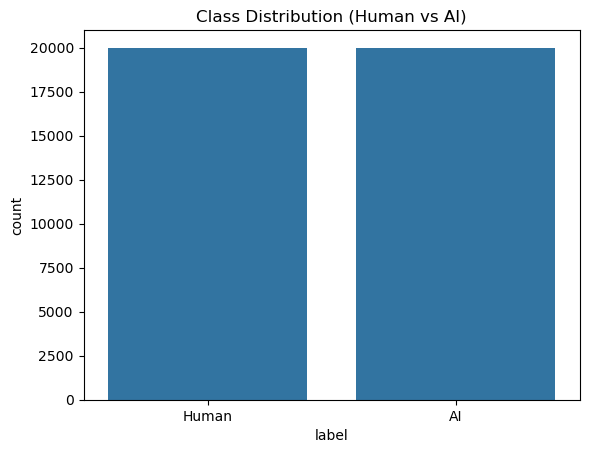

In [11]:
sns.countplot(data=df, x="label")
plt.title("Class Distribution (Human vs AI)")
plt.xticks([0,1], ["Human", "AI"])
plt.show()


In [12]:
df["char_len"] = df["text"].apply(len)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))


In [13]:
print("Character Length Summary:")
print(df["char_len"].describe())

print("\nWord Count Summary:")
print(df["word_count"].describe())


Character Length Summary:
count     40000.000000
mean       4246.140625
std        9149.592423
min           3.000000
25%         417.000000
50%        1378.000000
75%        5454.250000
max      890119.000000
Name: char_len, dtype: float64

Word Count Summary:
count    40000.000000
mean       638.249875
std       1107.465263
min          1.000000
25%         69.000000
50%        228.000000
75%        848.000000
max      41517.000000
Name: word_count, dtype: float64


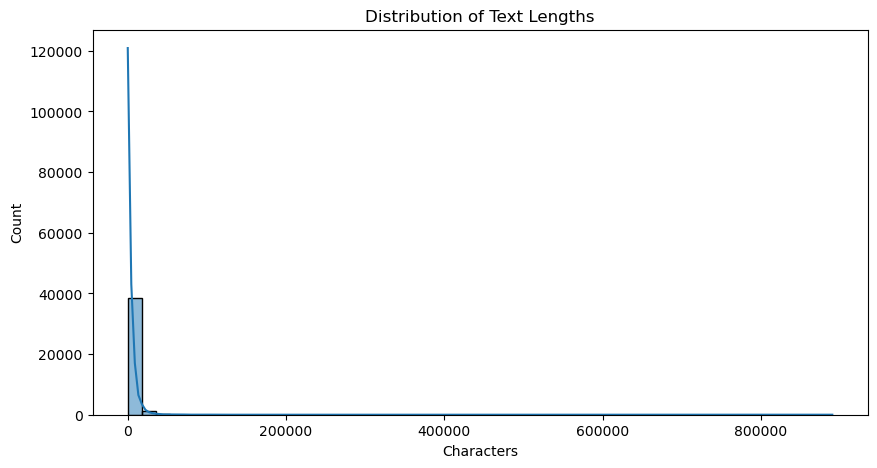

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(df["char_len"], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters")
plt.show()


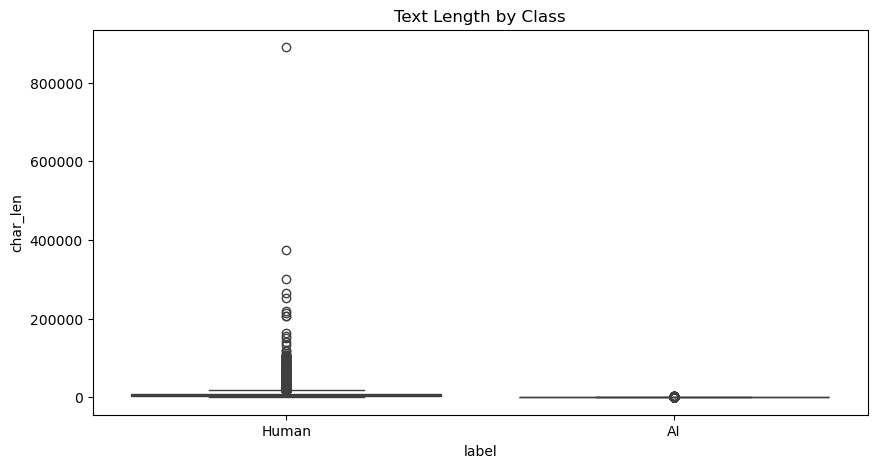

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="label", y="char_len")
plt.xticks([0,1], ["Human", "AI"])
plt.title("Text Length by Class")
plt.show()


In [16]:

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

tfidf_matrix = vectorizer.fit_transform(df["text"])
feature_names = vectorizer.get_feature_names_out()

def top_words(label, n=20):
    idx = df[df["label"] == label].index
    class_matrix = tfidf_matrix[idx].mean(axis=0)
    scores = list(zip(feature_names, class_matrix.A1))
    return sorted(scores, key=lambda x: x[1], reverse=True)[:n]

print("\nTop Human Words:")
print(top_words(0))

print("\nTop AI Words:")
print(top_words(1))



Top Human Words:
[('people', 0.033501362865174064), ('health', 0.029779962426699048), ('company', 0.021287217195733232), ('social', 0.021150335447788444), ('al', 0.021059170188007847), ('web', 0.02046628718084948), ('et', 0.020228496148714265), ('care', 0.01922342255542987), ('research', 0.018583836657022845), ('new', 0.018015927196370175), ('patients', 0.01781377345993749), ('information', 0.01752359099591567), ('patient', 0.017263461873951995), ('2020', 0.016869198510630876), ('data', 0.01640345641073156), ('life', 0.016149328030184002), ('work', 0.01561799814434511), ('business', 0.015530993039424493), ('2019', 0.015267052046450867), ('used', 0.015235607218398357)]

Top AI Words:
[('best', 0.02563180775995672), ('sure', 0.02562126131075401), ('make', 0.025187294061024188), ('help', 0.02221261957781642), ('include', 0.020807604015566448), ('way', 0.01932955984312478), ('additionally', 0.01890248017782684), ('use', 0.017634191389990617), ('start', 0.015475365848034783), ('online', 0.

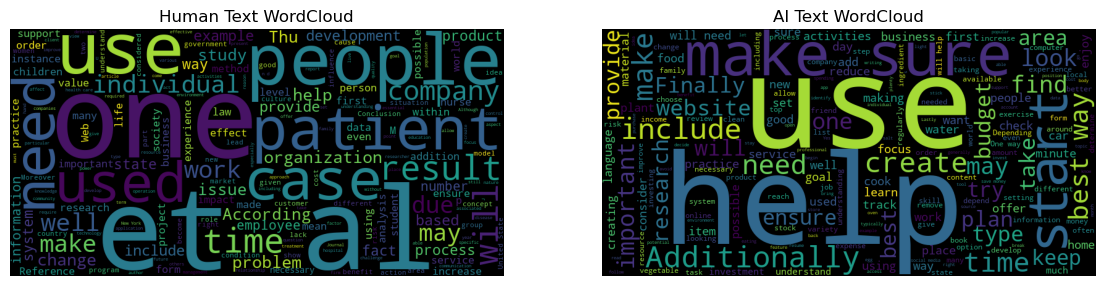

In [17]:

human_text = " ".join(df[df["label"] == 0]["text"])
ai_text = " ".join(df[df["label"] == 1]["text"])

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800, height=400).generate(human_text))
plt.axis("off")
plt.title("Human Text WordCloud")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800, height=400).generate(ai_text))
plt.axis("off")
plt.title("AI Text WordCloud")

plt.show()


In [18]:
duplicates = df["text"].duplicated().sum()
print("Number of duplicate entries:", duplicates)


Number of duplicate entries: 21


In [19]:
allowed = string.ascii_letters + string.digits + " "

df["special_char_count"] = df["text"].apply(
    lambda x: sum(1 for c in x if c not in allowed)
)

df.groupby("label")["special_char_count"].mean()


label
0    286.65065
1     14.50035
Name: special_char_count, dtype: float64

In [20]:

punct = string.punctuation

def count_punct(text):
    return sum(1 for ch in text if ch in punct)

df["punct_count"] = df["text"].apply(count_punct)

df.groupby("label")["punct_count"].mean()


label
0    220.39745
1     11.41895
Name: punct_count, dtype: float64

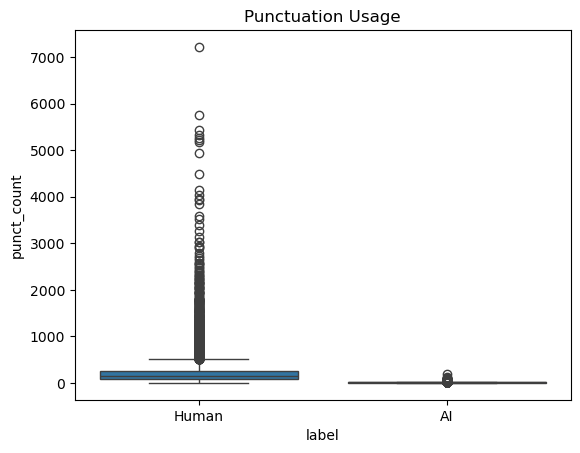

In [21]:
sns.boxplot(data=df, x="label", y="punct_count")
plt.xticks([0,1], ["Human", "AI"])
plt.title("Punctuation Usage")
plt.show()


In [22]:


df["sent_count"] = df["text"].apply(lambda x: len(nltk.sent_tokenize(x)))
df["avg_sent_len"] = df["word_count"] / df["sent_count"]

df.groupby("label")["avg_sent_len"].mean()


label
0    17.687787
1    20.409156
Name: avg_sent_len, dtype: float64

In [23]:

def pos_counts(text):
    doc = nlp(text[:2000])  # limit speed
    pos = [token.pos_ for token in doc]
    return {
        "NOUN": pos.count("NOUN"),
        "VERB": pos.count("VERB"),
        "ADJ":  pos.count("ADJ")
    }

pos_df = df["text"].head(1000).apply(pos_counts).apply(pd.Series)
pos_df["label"] = df["label"].head(1000)

pos_df.groupby("label").mean()


,NOUN,VERB,ADJ
label,,,
0,81.102,33.808,28.140
1,20.074,11.630,7.188
